# 2048 Afterstate Value Learning - Agents Comparison
**Reinforcement Learning with N-tuple Features**

---

## Overview

This project implements **Afterstate Value Learning** for the 2048 game with different agent training, demonstrating:
- Temporal difference learning with function approximation
- N-tuple feature extraction for pattern recognition  
- **agent training** with different learning rates
- Comprehensive performance analysis and validation
- Feature Analysis of Best Agent
- Visual gameplay demonstration


---

##  Problem Definition

**2048 Game**: Slide numbered tiles on a 4×4 grid to combine them and reach the 2048 tile.
- **State Space**: 4×4 grid with tiles (powers of 2)
- **Action Space**: 4 directional moves (Up, Down, Left, Right)
- **Reward**: Points from tile merges
- **Challenge**: Stochastic tile placement after each move

**Goal**: Learn optimal policy through afterstate value function approximation and find best exploration strategy.

##  Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import pickle
import os
import time
import pygame
from numba import njit
import math




# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Useful Functions

In [ ]:
@njit(fastmath=True)
def slide_row(row):
    non_zero = row[row != 0]
    if len(non_zero) == 0:
        return np.zeros_like(row), 0

    result = np.zeros_like(row)
    points = 0
    pos = 0
    i = 0

    while i < len(non_zero):
        if i + 1 < len(non_zero) and non_zero[i] == non_zero[i + 1]:
            merged_value = non_zero[i] * 2
            result[pos] = merged_value
            points += merged_value
            i += 2
        else:
            result[pos] = non_zero[i]
            i += 1
        pos += 1

    return result, points

@njit
def simulate_afterstate(board, action):
    new_board = board.copy().astype(np.int32)
    total_reward = 0

    if action == 0:  # Up
        for j in range(4):
            new_col, points = slide_row(new_board[:, j])
            new_board[:, j] = new_col
            total_reward += points
    elif action == 1:  # Right
        for i in range(4):
            new_row, points = slide_row(new_board[i, ::-1])
            new_board[i, :] = new_row[::-1]
            total_reward += points
    elif action == 2:  # Down
        for j in range(4):
            new_col, points = slide_row(new_board[::-1, j])
            new_board[:, j] = new_col[::-1]
            total_reward += points
    elif action == 3:  # Left
        for i in range(4):
            new_row, points = slide_row(new_board[i, :])
            new_board[i, :] = new_row
            total_reward += points

    return new_board, total_reward

@njit
def get_valid_moves(board):
    valid = []
    for direction in range(4):
        new_board, _ = simulate_afterstate(board, direction)
        if not np.array_equal(board, new_board):
            valid.append(direction)
    return valid

@njit
def check_game_over(board):
    return len(get_valid_moves(board)) == 0

## Game Environment

In [3]:
class Game2048:
    
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=np.int32)
        self.score = 0
        self.reset()
    
    def reset(self):
        self.board.fill(0)
        self.score = 0
        self.add_random_tile()
        self.add_random_tile()
        return self.board.copy()
    
    def add_random_tile(self):
        empty_positions = np.where(self.board == 0)
        if len(empty_positions[0]) > 0:
            idx = random.randint(0, len(empty_positions[0]) - 1)
            i, j = empty_positions[0][idx], empty_positions[1][idx]
            self.board[i, j] = 2 if random.random() < 0.9 else 4
    
    def move(self, direction, add_tile=True):
        prev_board = self.board.copy()
        new_board, reward = simulate_afterstate(self.board, direction)
        
        moved = not np.array_equal(prev_board, new_board)
        
        if moved:
            self.board = new_board
            self.score += reward
            if add_tile:
                self.add_random_tile()
        
        done = check_game_over(self.board)
        info = {'score': self.score, 'max_tile': int(np.max(self.board)), 'moved': moved}
        
        return self.board.copy(), reward, done, info

##  Random  Agent

In [ ]:
class RandomAgent:
    def choose_action(self, board, valid_actions):
        return random.choice(valid_actions)
    
    def evaluate(self, env, num_episodes=1000):
        scores, max_tiles = [], []
        
        for ep in range(num_episodes):  
            state = env.reset()
            episode_score = 0
            
            while not check_game_over(state):
                valid_moves = get_valid_moves(state)
                if not valid_moves:
                    break
                
                action = self.choose_action(state, valid_moves)
                state, reward, done, info = env.move(action)
                episode_score += reward
                
            scores.append(episode_score)
            max_tiles.append(int(np.max(state)))
        
        return {'scores': scores, 'max_tiles': max_tiles}

## Random Baseline Evaluation

 TILE DISTRIBUTION TABLE
Agent        Avg Score  Games 16    32    64    128   256   
------------------------------------------------------------
Random       1127       1000  0.1%  5.9%  36.1% 49.3% 8.6%  


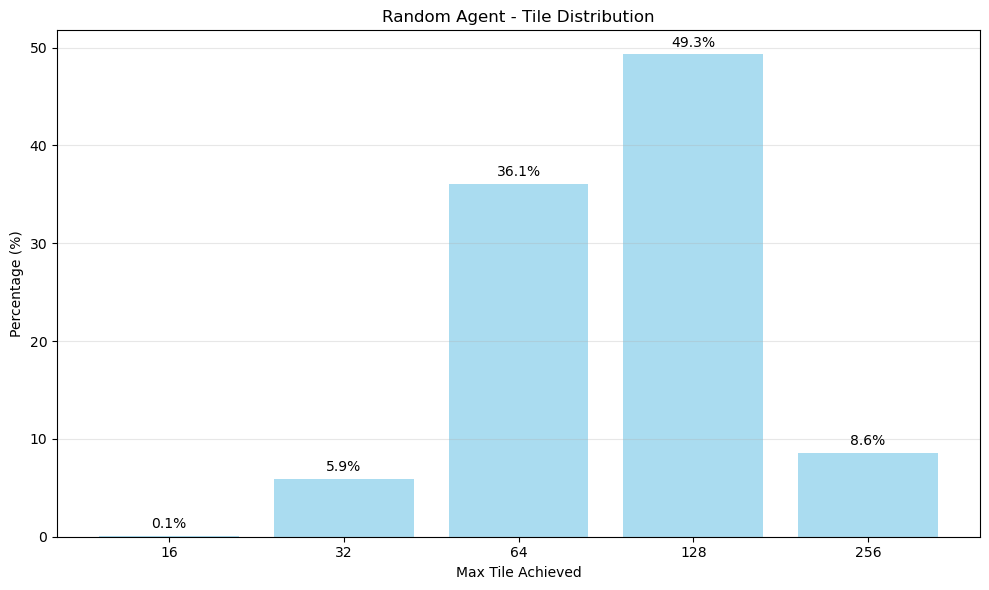

In [5]:
# Run evaluation
env = Game2048()
random_agent = RandomAgent()
random_results = random_agent.evaluate(env, num_episodes=1000)

# Calculate statistics
avg_score = np.mean(random_results['scores'])
max_score = max(random_results['scores'])
unique_tiles, counts = np.unique(random_results['max_tiles'], return_counts=True)

# Create tile distribution dictionary
tile_dist = {}
for tile, count in zip(unique_tiles, counts):
    tile_dist[int(tile)] = count / 1000 * 100

# Display results table
print(" TILE DISTRIBUTION TABLE")
print("=" * 80)
header = f"{'Agent':<12} {'Avg Score':<10} {'Games':<6}"
for tile in unique_tiles:
    header += f"{int(tile):<6}"
print(header)
print("-" * len(header))

# Format percentages for actual tiles found
percentages = [f"{tile_dist[int(tile)]:.1f}%" for tile in unique_tiles]
row = f"{'Random':<12} {avg_score:<10.0f} {'1000':<6}"
for pct in percentages:
    row += f"{pct:<6}"
print(row)

# Plot tile distribution
plt.figure(figsize=(10, 6))
tiles = list(tile_dist.keys())
percentages_vals = list(tile_dist.values())

bars = plt.bar(range(len(tiles)), percentages_vals, color='skyblue', alpha=0.7)
plt.xlabel('Max Tile Achieved')
plt.ylabel('Percentage (%)')
plt.title('Random Agent - Tile Distribution')
plt.xticks(range(len(tiles)), tiles)

# Add percentage labels on bars
for bar, pct in zip(bars, percentages_vals):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5, 
             f'{pct:.1f}%', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/random_agent.png', dpi=150, bbox_inches='tight')
plt.show()

##  N-tuple Feature 

In [ ]:
@njit(fastmath=True)
def board_to_log_fast(board):
    log_board = np.zeros((4, 4), dtype=np.int8)
    for i in range(4):
        for j in range(4):
            if board[i, j] > 0:
                log_board[i, j] = min(13, int(math.log2(board[i, j])))
    return log_board

@njit
def pattern_to_index_fast(pattern_values):
    index = 0
    multiplier = 1
    for val in pattern_values:
        index += val * multiplier
        multiplier *= 14
    return index

@njit
def get_rotated_position(i, j, rotation):
    if rotation == 0:  # 0 degrees
        return i, j
    elif rotation == 1:  # 90 degrees clockwise
        return j, 3 - i
    elif rotation == 2:  # 180 degrees
        return 3 - i, 3 - j
    elif rotation == 3:  # 270 degrees clockwise
        return 3 - j, i
    else:  # rotation >= 4 means reflection + rotation
        # First reflect horizontally
        j_reflected = 3 - j
        # Then rotate
        return get_rotated_position(i, j_reflected, rotation - 4)

@njit
def extract_pattern_symmetric(log_board, pattern_positions, symmetry):
    values = np.zeros(len(pattern_positions), dtype=np.int8)
    for idx in range(len(pattern_positions)):
        i, j = pattern_positions[idx]
        i_sym, j_sym = get_rotated_position(i, j, symmetry)
        values[idx] = log_board[i_sym, j_sym]
    return values

@njit
def evaluate_pattern_all_symmetries(log_board, pattern_positions, lut):
    total = 0.0
    for sym in range(8):
        values = extract_pattern_symmetric(log_board, pattern_positions, sym)
        index = pattern_to_index_fast(values)
        total += lut[index]
    return total


class Features:
    
    def __init__(self):
        
        base_patterns = [
            [(0,0), (0,1), (0,2), (0,3)],                      # Horizontal
            [(1,0), (1,1), (1,2), (1,3)],                      # Horizontal
            [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)],        # 2×3
            [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3)],        # 2×3
            [(0,0), (0,1), (1,0), (1,1)],                      # 2×2
            [(0,1), (0,2), (1,1), (1,2)],                      # 2×2
            [(1,1), (1,2), (2,1), (2,2)],                      # 2×2
            [(0,0), (0,1), (0,2), (1,2), (2,2)],               # L-shape
        ]
        
        # Convert to numpy arrays for Numba
        self.patterns_np = []
        self.luts = []
        self.lut_sizes = []
        
        for pattern in base_patterns:
            # Convert pattern to numpy array
            pattern_np = np.array(pattern, dtype=np.int8)
            self.patterns_np.append(pattern_np)
            
            # Initialize LUT
            lut_size = 14 ** len(pattern)
            self.lut_sizes.append(lut_size)
            lut = np.full(lut_size, 10.0, dtype=np.float32) 
            self.luts.append(lut)
        
        # Statistics
        total_weights = sum(self.lut_sizes)
        
    def evaluate(self, board):
        log_board = board_to_log_fast(board)
        total_value = 0.0
        
        # Evaluate each pattern with all symmetries
        for i, (pattern_np, lut) in enumerate(zip(self.patterns_np, self.luts)):
            total_value += evaluate_pattern_all_symmetries(log_board, pattern_np, lut)
        
        return total_value
    
    def update(self, board, td_error, alpha):
        log_board = board_to_log_fast(board)
        update_value = (alpha * td_error) / 8.0
        
        # Update each pattern
        for pattern_np, lut in zip(self.patterns_np, self.luts):
            # Update for all 8 symmetries
            for sym in range(8):
                values = extract_pattern_symmetric(log_board, pattern_np, sym)
                index = pattern_to_index_fast(values)
                lut[index] += update_value
    
    

##  Afterstate Value Learning Agent

In [7]:
class TDAfterstateAgent:

    def __init__(self, learning_rate=0.0025, gamma=1.0, epsilon=0.5):
        self.alpha = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.min_epsilon = 0.001

        self.network = Features()
        self.episodes_trained = 0
        self.td_errors = deque(maxlen=1000)

        # Training history tracking
        self.training_history = {
            'scores': [],
            'max_tiles': [],
            'td_errors_avg': [],
            'learning_rate': learning_rate
        }

    def choose_action(self, board, training=True):
        valid_actions = get_valid_moves(board)
        if not valid_actions:
            return -1

        if training and random.random() < self.epsilon:
            return valid_actions[random.randint(0, len(valid_actions) - 1)]

        best_value = float('-inf')
        best_action = valid_actions[0]

        for action in valid_actions:
            afterstate, immediate_reward = simulate_afterstate(board, action)
            future_value = self.network.evaluate(afterstate)
            total_value = immediate_reward + future_value

            if total_value > best_value:
                best_value = total_value
                best_action = action

        return best_action

    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        moves = 0

        while not check_game_over(state):
            action = self.choose_action(state, training=True)
            if action == -1:
                break

            afterstate, immediate_reward = simulate_afterstate(state, action)
            current_value = self.network.evaluate(afterstate)

            next_state, _, done, info = env.move(action, add_tile=True)
            moves += 1

            # Compute TD target
            if done or check_game_over(next_state):
                td_target = 0.0
            else:
                next_valid = get_valid_moves(next_state)
                next_value = float('-inf')

                for next_action in next_valid:
                    next_afterstate, _ = simulate_afterstate(next_state, next_action)
                    v = self.network.evaluate(next_afterstate)
                    if v > next_value:
                        next_value = v

                td_target = self.gamma * next_value

            # TD update
            td_error = td_target - current_value
            self.td_errors.append(abs(td_error))
            self.network.update(afterstate, td_error, self.alpha)

            total_reward += immediate_reward
            state = next_state

        # Update epsilon
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.min_epsilon)

        # Update training history
        self.training_history['scores'].append(total_reward)
        self.training_history['max_tiles'].append(int(np.max(state)))
        self.training_history['td_errors_avg'].append(np.mean(self.td_errors) if self.td_errors else 0)

        self.episodes_trained += 1

        return {
            'score': total_reward,
            'moves': moves,
            'td_error': np.mean(self.td_errors) if self.td_errors else 0,
            'max_tile': int(np.max(state)),
            'epsilon': self.epsilon
        }

    def evaluate(self, env, num_episodes=100):
        original_epsilon = self.epsilon
        self.epsilon = 0.0

        scores = []
        max_tiles = []

        for _ in range(num_episodes):
            state = env.reset()
            episode_score = 0

            while not check_game_over(state):
                action = self.choose_action(state, training=False)
                if action == -1:
                    break

                next_state, reward, done, info = env.move(action, add_tile=True)
                episode_score += reward
                state = next_state

            scores.append(episode_score)
            max_tiles.append(int(np.max(state)))

        self.epsilon = original_epsilon

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'max_score': max(scores),
            'min_score': min(scores),
            'success_rates': {
                tile: sum(1 for t in max_tiles if t >= tile) / num_episodes * 100
                for tile in [512, 1024, 2048, 4096]
            },
            'max_tiles': max_tiles,
            'scores': scores
        }

    def save_agent(self, filepath):
        agent_data = {
            'network': self.network,
            'episodes_trained': self.episodes_trained,
            'epsilon': self.epsilon,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'td_errors': list(self.td_errors),
            'training_history': self.training_history
        }
        with open(filepath, 'wb') as f:
            pickle.dump(agent_data, f)

    def load_agent(self, filepath):
        with open(filepath, 'rb') as f:
            agent_data = pickle.load(f)

        self.network = agent_data['network']
        self.episodes_trained = agent_data['episodes_trained']
        self.epsilon = agent_data['epsilon']
        self.alpha = agent_data['alpha']
        self.gamma = agent_data['gamma']
        self.td_errors = deque(agent_data.get('td_errors', []), maxlen=1000)

        # Load training history if available
        self.training_history = agent_data.get('training_history', {
            'scores': [],
            'max_tiles': [],
            'td_errors_avg': [],
            'learning_rate': self.alpha
        })


## Agents Training

In [ ]:
def train_agents(learning_rate, agent_id, num_episodes=50000):
    # Initialize agent and environment
    agent = TDAfterstateAgent(learning_rate=learning_rate)
    env = Game2048()


    for episode in range(num_episodes):
        agent.train_episode(env)


    # Save model
    model_path = f'models/agent_{agent_id+1}_lr_{learning_rate}.pkl'
    agent.save_agent(model_path)

    return {
        'agent_id': agent_id,
        'learning_rate': learning_rate,
        'model_path': model_path,
        'final_episodes': agent.episodes_trained
    }

# Training configuration
learning_rates = [0.001, 0.0025, 0.005 ,0.01]
results = []

# Train agents one after the other
for i, lr in enumerate(learning_rates):
    result = train_agents(lr, i)
    results.append(result)

##  Training Progress Visualization

 TRAINING SUMMARY TABLE (Last 1000 Episodes)
  Agent  Learning Rate  Episodes Avg Score Success Rate (2048+)  256  512  1024  2048  4096 8192
Agent 1         0.0025     50000     38086                82.9% 0.2% 1.8% 15.1% 59.8% 23.0% 0.1%
Agent 2         0.0050     50000     50849                92.6% 0.2% 1.4%  5.8% 41.1% 50.6% 0.9%
Agent 3         0.0100     50000     60888                93.6% 0.4% 2.5%  3.5% 24.1% 65.7% 3.8%
Agent 4         0.0500     50000     47895                93.7% 0.2% 0.7%  5.4% 44.5% 48.8% 0.4%


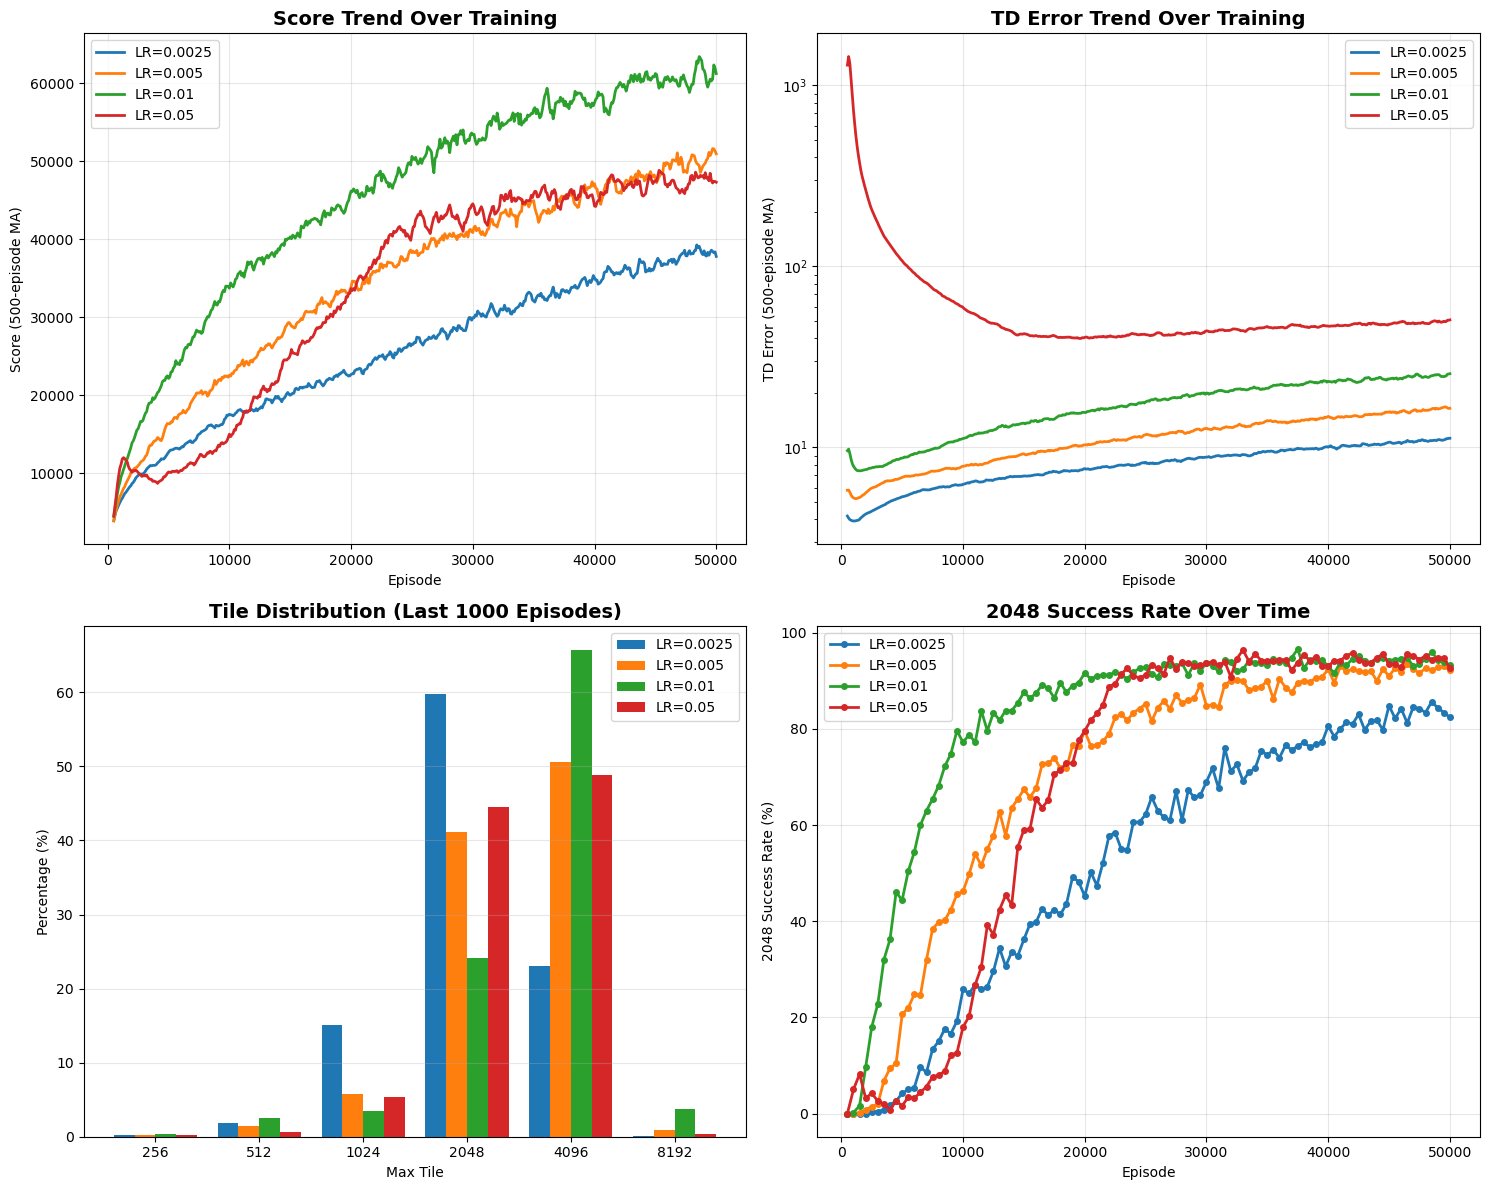

In [ ]:
agents = []
learning_rates = [0.0025 ,0.005 ,0.01 ,0.05]
for i, lr in enumerate(learning_rates):
    agent = TDAfterstateAgent()
    filepath = f'models/agent_{i+1}_lr_{lr}.pkl'
    agent.load_agent(filepath)
    agents.append(agent)

# Create comprehensive training summary table
def training_summary_table(agents):
    summary_data = []
    
    for i, agent in enumerate(agents):
        history = agent.training_history
        lr = history['learning_rate']
        scores = history['scores']
        max_tiles = history['max_tiles']
        
        # Last 1000 episodes stats
        recent_scores = scores[-1000:] if len(scores) >= 1000 else scores
        recent_tiles = max_tiles[-1000:] if len(max_tiles) >= 1000 else max_tiles
          
        # Calculate average score
        avg_score = np.mean(recent_scores)
        
        # Calculate success rate (2048+)
        success_count = sum(1 for tile in recent_tiles if tile >= 2048)
        success_rate = success_count / len(recent_tiles) * 100
        
        # Tile distribution
        tile_counts = {}
        for tile in recent_tiles:
            tile_counts[tile] = tile_counts.get(tile, 0) + 1
        
        # Get all unique tiles and sort them
        all_tiles = sorted(tile_counts.keys())
        
        row = {
            'Agent': f"Agent {i+1}",
            'Learning Rate': lr,
            'Episodes': len(scores),
            'Avg Score': f"{avg_score:.0f}",
            'Success Rate (2048+)': f"{success_rate:.1f}%"
        }
        
        # Add tile distribution for all tiles
        for tile in all_tiles:
            count = tile_counts[tile]
            percentage = count / len(recent_tiles) * 100
            row[tile] = f"{percentage:.1f}%"
        
        summary_data.append(row)
    
    return pd.DataFrame(summary_data)

# Create and display the comprehensive table
print(" TRAINING SUMMARY TABLE (Last 1000 Episodes)")
print("=" * 100)

df = training_summary_table(agents)
# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df.to_string(index=False))


# Create 4 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. Score Trend
ax1.set_title('Score Trend Over Training', fontsize=14, fontweight='bold')
for i, agent in enumerate(agents):
    scores = agent.training_history['scores']
    # Moving average with window of 500
    window = 500
    if len(scores) >= window:
        ma_scores = np.convolve(scores, np.ones(window)/window, mode='valid')
        episodes = np.arange(window-1, len(scores))
        ax1.plot(episodes[::100], ma_scores[::100], 
                 label=f'LR={agent.training_history["learning_rate"]}', 
                 color=colors[i], linewidth=2)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score (500-episode MA)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. TD Error Trend
ax2.set_title('TD Error Trend Over Training', fontsize=14, fontweight='bold')
for i, agent in enumerate(agents):
    td_errors = agent.training_history['td_errors_avg']
    # Moving average
    window = 500
    if len(td_errors) >= window:
        ma_td = np.convolve(td_errors, np.ones(window)/window, mode='valid')
        episodes = np.arange(window-1, len(td_errors))
        ax2.plot(episodes[::100], ma_td[::100], 
                 label=f'LR={agent.training_history["learning_rate"]}', 
                 color=colors[i], linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('TD Error (500-episode MA)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Tile Distribution (Last 1000 episodes)
ax3.set_title('Tile Distribution (Last 1000 Episodes)', fontsize=14, fontweight='bold')

# Find all unique tiles across all agents
all_unique_tiles = set()
for agent in agents:
    recent_tiles = agent.training_history['max_tiles'][-1000:]
    all_unique_tiles.update(recent_tiles)

# Sort tiles and convert to list
tiles_to_show = sorted(list(all_unique_tiles))
width = 0.35 if len(agents) == 2 else 0.8 / len(agents)
x_positions = np.arange(len(tiles_to_show))

for i, agent in enumerate(agents):
    recent_tiles = agent.training_history['max_tiles'][-1000:]
    tile_percentages = []
    for tile in tiles_to_show:
        percentage = sum(1 for t in recent_tiles if t == tile) / len(recent_tiles) * 100
        tile_percentages.append(percentage)
    
    ax3.bar(x_positions + i*width, tile_percentages, width, 
            label=f'LR={agent.training_history["learning_rate"]}', color=colors[i])

ax3.set_xlabel('Max Tile')
ax3.set_ylabel('Percentage (%)')
ax3.set_xticks(x_positions + width * (len(agents)-1) / 2)
ax3.set_xticklabels([str(int(tile)) for tile in tiles_to_show])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Success Rate Over Time (2048 tile) 
ax4.set_title('2048 Success Rate Over Time', fontsize=14, fontweight='bold')
for i, agent in enumerate(agents):
    max_tiles = agent.training_history['max_tiles']
    window = 500
    
    # Calculate success rates every 500 episodes
    episodes = []
    success_rates = []
    
    for j in range(window, len(max_tiles)+1, 500):
        recent_tiles = max_tiles[j-window:j]
        success_rate = sum(1 for t in recent_tiles if t >= 2048) / len(recent_tiles) * 100
        episodes.append(j)
        success_rates.append(success_rate)
    
    if episodes:  # Only plot if we have data
        ax4.plot(episodes, success_rates, 
                 label=f'LR={agent.training_history["learning_rate"]}', 
                 color=colors[i], linewidth=2, marker='o', markersize=4)

ax4.set_xlabel('Episode')
ax4.set_ylabel('2048 Success Rate (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

## Agents Validation

In [ ]:
def validate_agents(learning_rates, validation_episodes=1000):
    validation_results = []
    env = Game2048()
    
    for i, lr in enumerate(learning_rates): 
        # Load agent
        agent = TDAfterstateAgent()
        filepath = f'models/agent_{i+1}_lr_{lr}.pkl'
        agent.load_agent(filepath)
        
        # Use the existing evaluate method
        result = agent.evaluate(env, num_episodes=validation_episodes)
        result['agent_id'] = i
        result['learning_rate'] = lr
        
        validation_results.append(result)
    
    return validation_results

learning_rates = [0.0025 ,0.005 ,0.01 ,0.05]
validation_results = validate_agents(learning_rates)

##  Validation Agents Visualization


 TILE DISTRIBUTION TABLE 
  Agent  Learning Rate Avg Score  Games  256  512  1024  2048  4096 8192
Agent 1         0.0025     41081   1000 0.1% 1.0% 11.9% 56.9% 29.9% 0.2%
Agent 2         0.0050     53691   1000 0.2% 1.2%  4.3% 38.8% 53.7% 1.8%
Agent 3         0.0100     62704   1000 0.4% 1.0%  2.8% 23.4% 68.4% 4.0%
Agent 4         0.0500     47569   1000 0.1% 0.6%  4.5% 47.3% 47.2% 0.3%


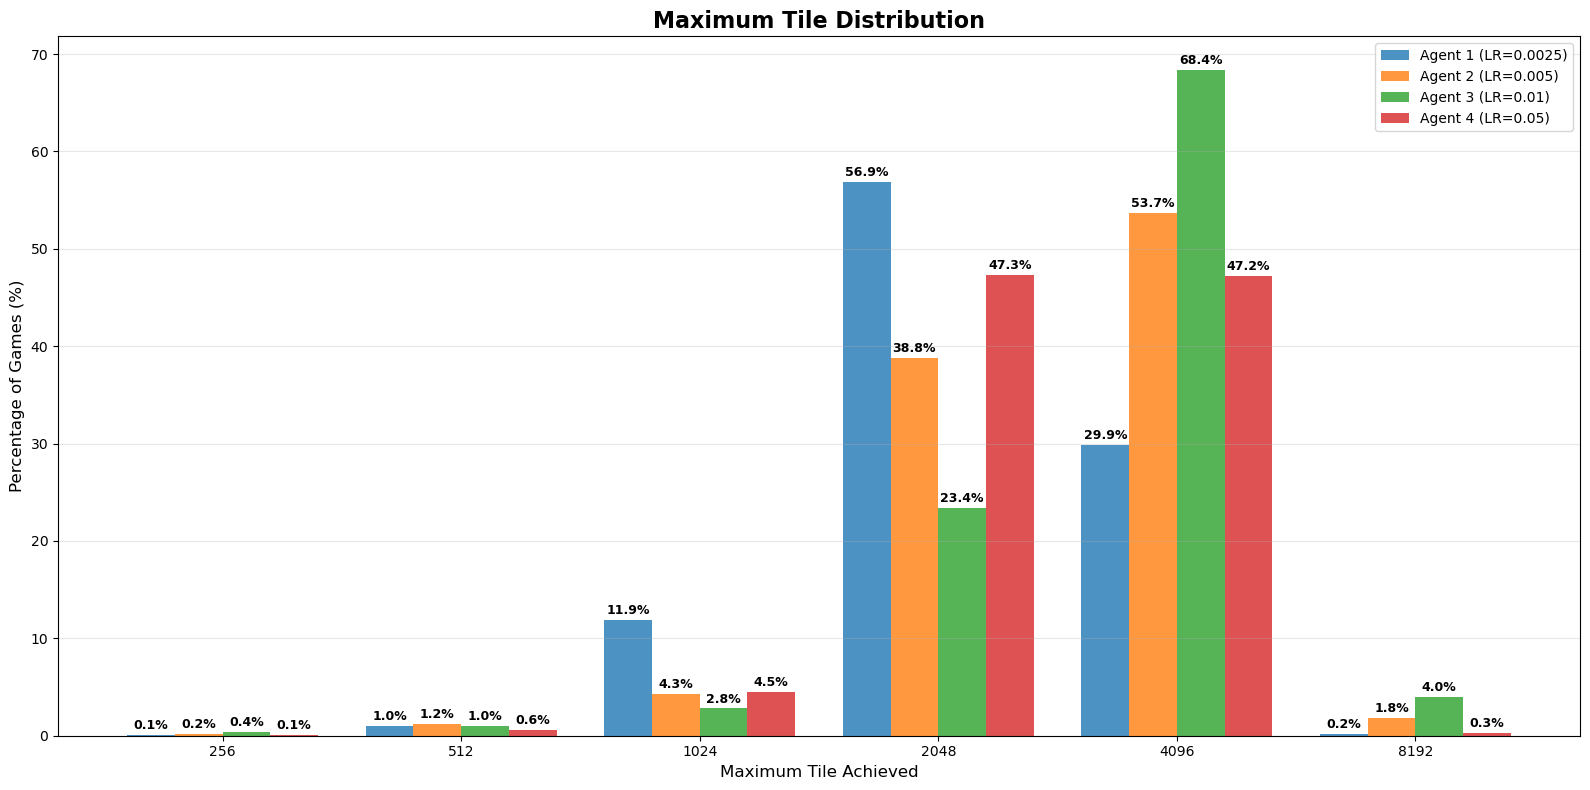

In [ ]:
def tile_distribution_table(validation_results):
    # Collect all unique tiles across all agents
    all_tiles = set()
    for result in validation_results:
        all_tiles.update(result['max_tiles'])
    
    sorted_tiles = sorted(all_tiles)
    
    # Create table data
    table_data = []
    
    for result in validation_results:
        agent_id = result['agent_id']
        lr = result['learning_rate']
        max_tiles = result['max_tiles']
        scores = result['scores']
        
        # Count occurrences of each tile
        tile_counts = {}
        for tile in max_tiles:
            tile_counts[tile] = tile_counts.get(tile, 0) + 1
        
        # Create row data
        row = {
            'Agent': f"Agent {agent_id+1}",
            'Learning Rate': lr,
            'Avg Score': f"{np.mean(scores):.0f}",
            'Games': len(max_tiles)
        }
        
        # Add percentage for each tile 
        for tile in sorted_tiles:
            count = tile_counts.get(tile, 0)
            percentage = count / len(max_tiles) * 100
            row[f'{tile}'] = f"{percentage:.1f}%"
        
        table_data.append(row)
    
    return pd.DataFrame(table_data), sorted_tiles

# Create and display the table
df, all_tiles_sorted = tile_distribution_table(validation_results)

print(f"\n TILE DISTRIBUTION TABLE ")
print("=" * 80)


# Display with better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df.to_string(index=False))

# Create visualization 
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 8))

# Use ALL tiles that appeared in results
tiles_to_show = all_tiles_sorted
width = 0.2
x_positions = np.arange(len(tiles_to_show))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, result in enumerate(validation_results):
    max_tiles = result['max_tiles']
    tile_percentages = []
    
    for tile in tiles_to_show:
        exact_count = sum(1 for t in max_tiles if t == tile)
        percentage = exact_count / len(max_tiles) * 100
        tile_percentages.append(percentage)
    
    bars = ax.bar(x_positions + i*width, tile_percentages, width, 
                  label=f'Agent {i+1} (LR={result["learning_rate"]})', 
                  color=colors[i], alpha=0.8)
    
    # Add value labels on bars 
    for j, (bar, percentage) in enumerate(zip(bars, tile_percentages)):
        if percentage > 0.0: 
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                   f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_title('Maximum Tile Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Maximum Tile Achieved', fontsize=12)
ax.set_ylabel('Percentage of Games (%)', fontsize=12)
ax.set_xticks(x_positions + width * 1.5)
ax.set_xticklabels([str(tile) for tile in tiles_to_show])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/validation_results.png', dpi=150, bbox_inches='tight')
plt.show()


## Feature Analysis of Best Agent

=== CRITICAL LEARNING INSIGHTS (Normalized: -10 from all weights) ===
Note: Means calculated only on learned weights (excluding 0)
Learning Coverage: 6,004,809/15,788,976 (38.0%) weights learned from experience
Default Weights: 9,784,167 (62.0%) remained at neutral default (0)

=== PATTERN STATISTICS TABLE (Normalized: -10, Mean/Std/Importance exclude 0) ===
Mean, Std & Importance: calculated only on learned weights (non-zero)

   Pattern  Mean       Std         Min        Max  Importance  Positive  Negative    Zero   Total
    2x2 TL 0.865 23.445000  -82.946999 180.675995      14.732     14645     18626    5145   38416
    2x2 TM 0.844 22.075001  -68.470001 151.397003      14.670     15609     18495    4312   38416
     Row 2 0.891 21.414000  -67.950996 189.468994      12.542     13170     19130    6116   38416
     Row 1 0.892 23.190001 -104.862000 216.942993      12.512     11999     20290    6127   38416
    2x2 BM 0.852 17.295000  -37.493000  81.600998      12.084     15868     17

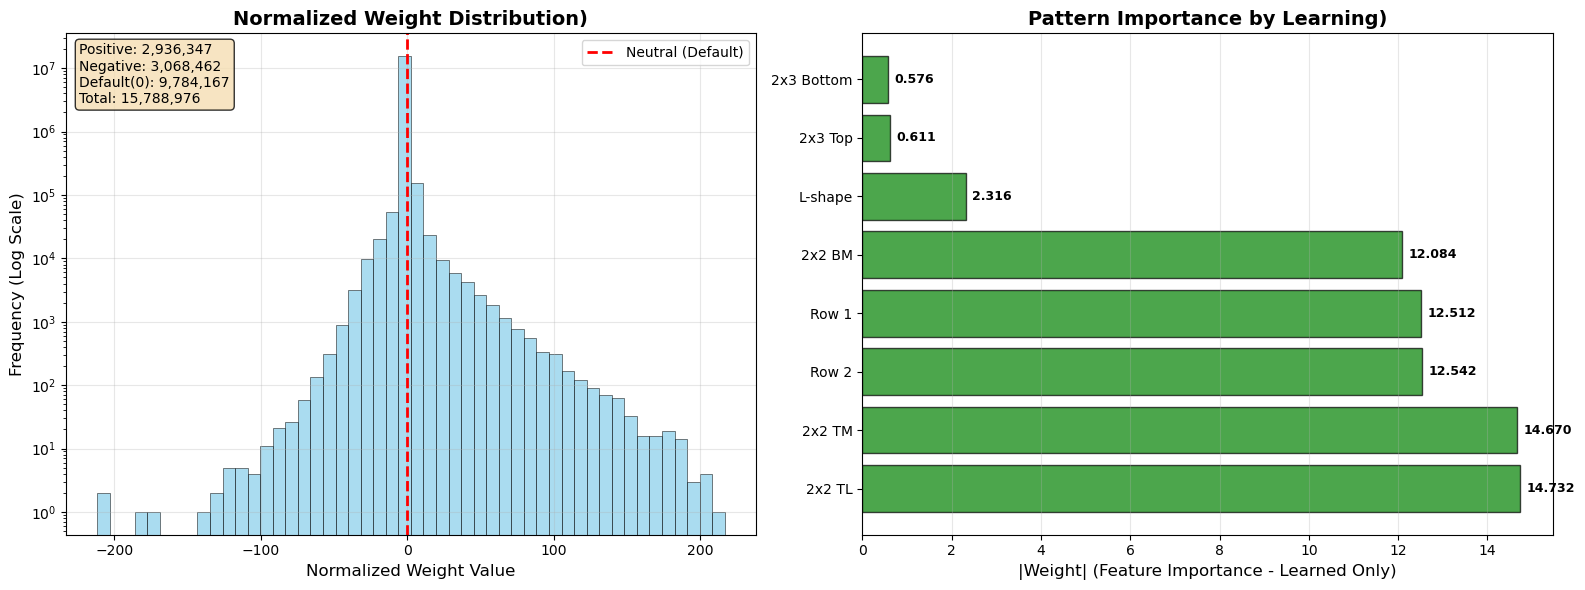

In [ ]:
def create_weight_analysis_plots(agent_filepath):
    # Load the agent
    agent = TDAfterstateAgent()
    agent.load_agent(agent_filepath)
    network = agent.network
    
    # Pattern names
    pattern_names = ['Row 1', 'Row 2', '2x3 Top', '2x3 Bottom', 
                    '2x2 TL', '2x2 TM', '2x2 BM', 'L-shape']
    
    # Collect all weights and pattern statistics (excluding 10.0)
    all_learned_weights = []
    pattern_stats = []
    
    for i, (pattern_name, lut) in enumerate(zip(pattern_names, network.luts)):
        # Normalize by subtracting 10 (so 10 becomes 0)
        normalized_lut = lut - 10.0
        all_learned_weights.extend(normalized_lut)  
        
        # Calculate statistics on normalized weights
        # For Mean, Std, and Importance: exclude 0 values (originally 10.0)
        non_zero_weights = normalized_lut[normalized_lut != 0]
        
        if len(non_zero_weights) > 0:
            mean_weight = np.mean(non_zero_weights) 
            std_weight = np.std(non_zero_weights)   
            abs_mean = np.mean(np.abs(non_zero_weights)) 
        else:
            mean_weight = 0  
            std_weight = 0  
            abs_mean = 0
            
        # For Min, Max: use all normalized weights (including 0)
        min_weight = np.min(normalized_lut)
        max_weight = np.max(normalized_lut)
        positive_count = np.sum(normalized_lut > 0)
        negative_count = np.sum(normalized_lut < 0)
        zero_count = np.sum(normalized_lut == 0)
        total_weights = len(normalized_lut)
        
        pattern_stats.append({
            'Pattern': pattern_name,
            'Mean': mean_weight,
            'Std': std_weight,
            'Min': min_weight,
            'Max': max_weight,
            'Importance': abs_mean,
            'Positive': positive_count,
            'Negative': negative_count,
            'Zero': zero_count,
            'Total': total_weights,
        })
    
    all_learned_weights = np.array(all_learned_weights)
    
    # Print critical and interesting statistics first
    total_positions = len(all_learned_weights)
    zero_weights = np.sum(all_learned_weights == 0)
    positive_weights = np.sum(all_learned_weights > 0)
    negative_weights = np.sum(all_learned_weights < 0)
    learned_weights = positive_weights + negative_weights  
    
    print("=== CRITICAL LEARNING INSIGHTS (Normalized: -10 from all weights) ===")
    print("Note: Means calculated only on learned weights (excluding 0)")
    print(f"Learning Coverage: {learned_weights:,}/{total_positions:,} ({100*learned_weights/total_positions:.1f}%) weights learned from experience")
    print(f"Default Weights: {zero_weights:,} ({100*zero_weights/total_positions:.1f}%) remained at neutral default (0)\n")

    

    # Create and display pattern statistics table
    df = pd.DataFrame(pattern_stats)
    df = df.sort_values('Importance', ascending=False)
    
    # Round numeric columns for better display
    numeric_cols = ['Mean', 'Std', 'Min', 'Max', 'Importance' ]
    for col in numeric_cols:
        df[col] = df[col].round(3)
    
    print("=== PATTERN STATISTICS TABLE (Normalized: -10, Mean/Std/Importance exclude 0) ===")
    print("Mean, Std & Importance: calculated only on learned weights (non-zero)\n")
    # Display with nice formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    print(df.to_string(index=False))
    print()
    
    # Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Weight Distribution (normalized, including zeros)
    # Create histogram
    n, bins, patches = ax1.hist(all_learned_weights, bins=50, alpha=0.7, color='skyblue', 
                               edgecolor='black', linewidth=0.5)
    
    # Add zero line
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral (Default)')
    
    # Configure plot 1
    ax1.set_xlabel('Normalized Weight Value', fontsize=12)
    ax1.set_ylabel('Frequency (Log Scale)', fontsize=12)
    ax1.set_title('Normalized Weight Distribution)', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add count text box
    textstr = f'Positive: {positive_weights:,}\nNegative: {negative_weights:,}\nDefault(0): {zero_weights:,}\nTotal: {total_positions:,}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # Plot 2: Pattern Importance
    sorted_patterns = df.copy()
    
    names = sorted_patterns['Pattern'].tolist()
    importances = sorted_patterns['Importance'].tolist()
    means = sorted_patterns['Mean'].tolist()
    colors = ['green' if mean > 0 else 'red' for mean in means]
    
    bars = ax2.barh(names, importances, color=colors, alpha=0.7, edgecolor='black')
    
    # Configure plot 2
    ax2.set_xlabel('|Weight| (Feature Importance - Learned Only)', fontsize=12)
    ax2.set_title('Pattern Importance by Learning)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    
    # Add values on bars
    for i, (bar, importance) in enumerate(zip(bars, importances)):
        ax2.text(importance + max(importances) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('results/feature_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    return pattern_stats, all_learned_weights

pattern_stats, weights = create_weight_analysis_plots('models/agent_3_lr_0.01.pkl')

##  Visual Gameplay Demo

In [ ]:
class GameVisualizer:
    
    def __init__(self, window_size: int = 500):
        pygame.init()
        self.window_size = window_size
        self.screen = pygame.display.set_mode((window_size, window_size + 100))
        pygame.display.set_caption("2048 Afterstate Learning Demo")
        self.font_large = pygame.font.Font(None, 48)
        self.font_small = pygame.font.Font(None, 24)
        self.clock = pygame.time.Clock()
        
        self.colors = {
            0: (205, 193, 180), 2: (238, 228, 218), 4: (237, 224, 200),
            8: (242, 177, 121), 16: (245, 149, 99), 32: (246, 124, 95),
            64: (246, 94, 59), 128: (237, 207, 114), 256: (237, 204, 97),
            512: (237, 200, 80), 1024: (237, 197, 63), 2048: (237, 194, 46),
            4096: (237, 190, 30), 8192: (237, 185, 15)
        }

    def render(self, board: np.ndarray, score: float, move_info: str = ""):
        self.screen.fill((187, 173, 160))
        
        cell_size = (self.window_size - 50) // 4
        padding = 10
        
        for i in range(4):
            for j in range(4):
                x = 25 + j * cell_size + padding // 2
                y = 25 + i * cell_size + padding // 2
                value = board[i, j]
                
                color = self.colors.get(value, (60, 58, 50))
                pygame.draw.rect(self.screen, color,
                                    (x, y, cell_size - padding, cell_size - padding),
                                    border_radius=6)
                
                if value > 0:
                    text_color = (119, 110, 101) if value <= 4 else (249, 246, 242)
                    text = self.font_large.render(str(value), True, text_color)
                    text_rect = text.get_rect(center=(x + (cell_size - padding) // 2,
                                                        y + (cell_size - padding) // 2))
                    self.screen.blit(text, text_rect)
        
        # Info display
        y_offset = self.window_size + 10
        score_text = self.font_small.render(f"Score: {score:.0f}", True, (255, 255, 255))
        info_text = self.font_small.render(move_info, True, (255, 255, 255))
        
        self.screen.blit(score_text, (20, y_offset))
        self.screen.blit(info_text, (20, y_offset + 30))
        
        pygame.display.flip()
        self.clock.tick(30)

    def close(self):
        pygame.quit()

def run_demo_game(agent, env_class):
    if agent.episodes_trained == 0:
        print(" No trained agent available for demo")
        return
    
    # Create environment instance
    env = env_class()
    visualizer = GameVisualizer()
    
    # Speed control settings
    speeds = [0.025, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]  # seconds between moves
    speed_names = ["Super Fast", "Very Fast", "Fast", "Normal", "Slow", "Very Slow", "Super Slow"]
    current_speed_idx = 2  # Start with "Normal"
    
    print(" Demo Controls:")
    print("   ESC - quit")
    print("   SPACE - pause/resume")
    print("   + or ↑ - increase speed (faster)")
    print("   - or ↓ - decrease speed (slower)")
    print("   Close window - exit")
    print(f"   Starting speed: {speed_names[current_speed_idx]}")
    
    action_names = ["↑ UP", "→ RIGHT", "↓ DOWN", "← LEFT"]
    
    try:
        state = env.reset()
        move_count = 0
        paused = False
        
        while not check_game_over(state):
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    raise KeyboardInterrupt
                elif event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        raise KeyboardInterrupt
                    elif event.key == pygame.K_SPACE:
                        paused = not paused
                    # Speed controls
                    elif event.key in [pygame.K_PLUS, pygame.K_EQUALS, pygame.K_UP]:
                        if current_speed_idx > 0:
                            current_speed_idx -= 1
                            print(f" Speed: {speed_names[current_speed_idx]} ({speeds[current_speed_idx]:.2f}s)")
                    elif event.key in [pygame.K_MINUS, pygame.K_DOWN]:
                        if current_speed_idx < len(speeds) - 1:
                            current_speed_idx += 1
                            print(f" Speed: {speed_names[current_speed_idx]} ({speeds[current_speed_idx]:.2f}s)")
            
            if paused:
                # Get current score properly
                current_score = getattr(env, 'score', 0)
                pause_info = f"PAUSED - Press SPACE to continue | Speed: {speed_names[current_speed_idx]}"
                visualizer.render(state, current_score, pause_info)
                time.sleep(0.1)
                continue
            
            # Agent makes move
            valid_actions = get_valid_moves(state)
            if not valid_actions:
                break
                
            action = agent.choose_action(state, training=False)
            action_name = action_names[action]
            
            next_state, reward, done, info = env.move(action, add_tile=True)
            move_count += 1
            
            # Display move
            info_text = f"Move {move_count}: {action_name} | Speed: {speed_names[current_speed_idx]}"
            if reward > 0:
                info_text += f" (+{reward:.0f})"
            
            # Get current score 
            current_score = getattr(env, 'score', 0)
            visualizer.render(state, current_score, info_text)
            time.sleep(speeds[current_speed_idx])  # Use current speed setting
            
            state = next_state
            
            if done:
                break
        
        # Game finished
        final_score = getattr(env, 'score', 0)
        final_info = f"Game Over! Moves: {move_count}, Max: {int(np.max(state))} | Final Speed: {speed_names[current_speed_idx]}"
        visualizer.render(state, final_score, final_info)
        
        print(f" Demo finished:")
        print(f" Score: {final_score:.0f}")
        print(f" Max Tile: {int(np.max(state))}")
        print(f" Moves: {move_count}")
        
        # Wait for manual close
        running = True
        while running:
            for event in pygame.event.get():
                if event.type == pygame.QUIT or event.type == pygame.KEYDOWN:
                    running = False
            
            visualizer.render(state, final_score, "Demo finished - Press any key or close window to exit")
            time.sleep(0.1)
    
    except KeyboardInterrupt:
        print("\n Demo stopped")
    
    finally:
        visualizer.close()


agent = TDAfterstateAgent()
agent.load_agent('models/agent_3_lr_0.01.pkl')
run_demo_game(agent, Game2048)

 Demo Controls:
   ESC - quit
   SPACE - pause/resume
   + or ↑ - increase speed (faster)
   - or ↓ - decrease speed (slower)
   Close window - exit
   Starting speed: Fast
 Speed: Very Fast (0.05s)
 Speed: Super Fast (0.03s)
 Demo finished:
 Score: 71140
 Max Tile: 4096
 Moves: 3246
